# LSTM

## Initialize

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%matplotlib inline
import matplotlib.pyplot as plt, numpy as np,  pandas as pd
from sklearn.preprocessing import MinMaxScaler
import datetime 
import tensorflow as tf

root_notebook_folder = os.path.abspath('.')
data_folder = os.path.abspath('./local_data')

## Display data

In [2]:
data = pd.read_csv(os.path.join(data_folder, 'airline-passengers.csv'))
data['Date'] = pd.to_datetime(data['Month'])
data.head()

,Month,Passengers,Date
0,1949-01,112,1949-01-01
1,1949-02,118,1949-02-01
2,1949-03,132,1949-03-01
3,1949-04,129,1949-04-01
4,1949-05,121,1949-05-01


In [3]:
data['Month'] = [datetime.date(d, m, 1) for d, m in zip(data['Month'].str[:4].astype(int), data['Month'].str[-2:].astype(int))]

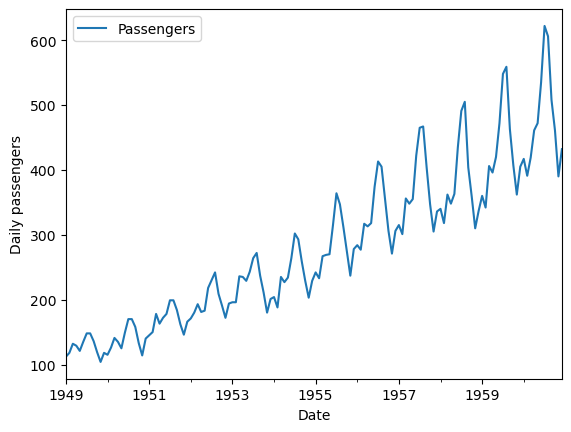

In [4]:
data.plot(x='Date',y='Passengers')
plt.ylabel('Daily passengers');

## Example 1: predict next month. 

### Data loading

In [5]:
data.head(10)

,Month,Passengers,Date
0,1949-01-01,112,1949-01-01
1,1949-02-01,118,1949-02-01
2,1949-03-01,132,1949-03-01
3,1949-04-01,129,1949-04-01
4,1949-05-01,121,1949-05-01
5,1949-06-01,135,1949-06-01
6,1949-07-01,148,1949-07-01
7,1949-08-01,148,1949-08-01
8,1949-09-01,136,1949-09-01
9,1949-10-01,119,1949-10-01


In [6]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        # for every time series object we have in the original data create for X a sequence of time series.
        # Y is allways the next time after the time series.
        _x = data.iloc[i:(i+seq_length)]
        _y = data.iloc[i+seq_length]
        x.append(_x)
        y.append(_y)
    return np.array(x),np.array(y)

seq_length = 4
# split into train and test sets
train_size = int(len(data) * 0.7)-seq_length-1 # 70% of the data minus one seq_length because we don't want overlapping with the test data.
test_size = len(data) - (train_size + 1) # it is missing also the decrease of seq_length.

train_data = data[['Passengers']].iloc[:train_size].copy()
test_data = data[['Passengers']].iloc[-test_size:].copy()

#normalize the data:
sc = MinMaxScaler() # scaling between 0 and 1.
sc.fit(train_data[['Passengers']])

train_data[['Passengers']] = sc.transform(train_data[['Passengers']])
test_data[['Passengers']] = sc.transform(test_data[['Passengers']])

# create train and test sets
trainX, trainY = sliding_windows(train_data, seq_length)
testX, testY = sliding_windows(test_data, seq_length)


In [7]:
trainX.shape # [batch_size, time_stamps, features], this is default and is set by time_major=False. 

(90, 4, 1)

### Define the model

In [8]:
def generate_model():
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM,  Dense
    model =  Sequential()
    model.add(LSTM(units=4)) # , input_shape=(1, seq_length))) # number of features, # of time stampos
    model.add(Dense(1))
    return model

~2min

In [9]:
model_file_name = os.path.join(data_folder, 'Airline Passengers - LSTM-1')

if not os.path.isdir(model_file_name):  # run the model only if it doesn't exist.  
    model = generate_model()
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=2000, batch_size=len(trainX), verbose=0)    
    pd.DataFrame(history.history).to_csv(model_file_name + '.csv')
    model.save(model_file_name)    
    
model = tf.keras.models.load_model(model_file_name)
history = pd.read_csv(model_file_name + '.csv', index_col=0)

<AxesSubplot:>

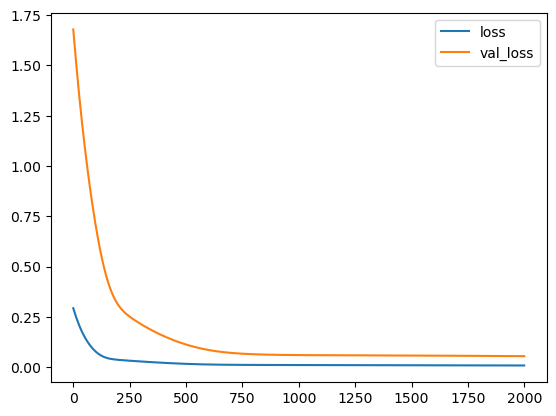

In [10]:
history.plot()

### Demonstrate predictions

2/2 [==============================] - 0s 0s/step


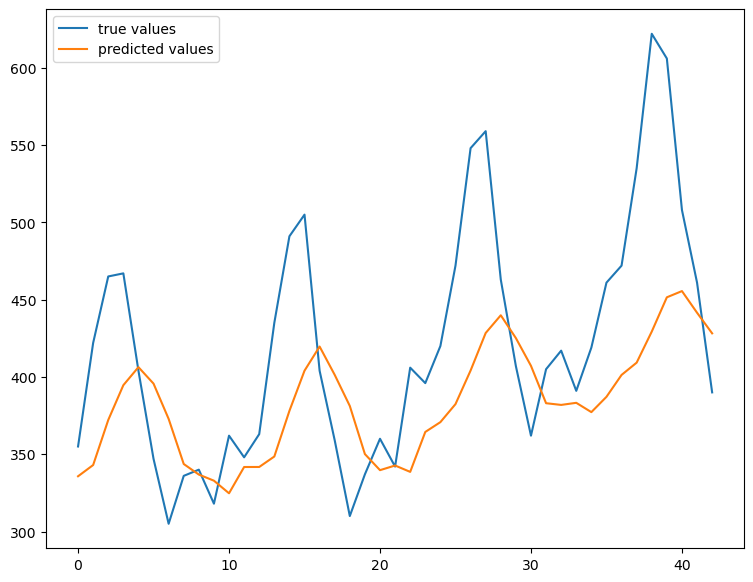

In [11]:
predY = model.predict(testX)
plt.figure(figsize=(9,7))
plt.plot(sc.inverse_transform(testY), label='true values') # inverse, de-normalizing the data.
plt.plot(sc.inverse_transform(predY), label='predicted values')
plt.legend()

## Example 2: predict in $t=12$ months. 

### Data loading

In [12]:
def sliding_windows(data, seq_length, future_t):
    # instead of predicting the next time series, we predict the nex+future_t. for example, in march to predict next march instead of april.
    x = []
    y = []

    for i in range(len(data)-seq_length-future_t):
        _x = data.iloc[i:(i+seq_length)]
        _y = data.iloc[i+seq_length+future_t]
        x.append(_x)
        y.append(_y)
    return np.array(x),np.array(y)

seq_length = 4
future_t = 12
# split into train and test sets
train_size = int(len(data) * 0.7)-seq_length-future_t
test_size = len(data) -(train_size +future_t)

train_data = data[['Passengers']].iloc[:train_size].copy()
test_data = data[['Passengers']].iloc[-test_size:].copy()


#normalize the data:
sc = MinMaxScaler()
sc.fit(train_data[['Passengers']])

train_data[['Passengers']] = sc.transform(train_data[['Passengers']])
test_data[['Passengers']] = sc.transform(test_data[['Passengers']])

# create train and test sets
trainX, trainY = sliding_windows(train_data, seq_length, future_t=12)
testX, testY = sliding_windows(test_data, seq_length, future_t=12)


### Define the model

We'll be using exactly the same model class. 

### Train the model

In [13]:
model_file_name = os.path.join(data_folder, 'Airline Passengers - LSTM-1-b')
model = generate_model()
if not os.path.isdir(model_file_name):    
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=2000, batch_size=len(trainX), verbose=0)    
    pd.DataFrame(history.history).to_csv(model_file_name + '.csv')
    model.save(model_file_name)    
    
model = tf.keras.models.load_model(model_file_name)
history = pd.read_csv(model_file_name + '.csv', index_col=0)

<AxesSubplot:>

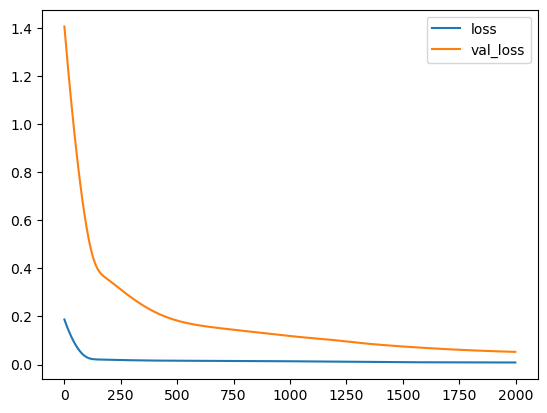

In [14]:
history.plot()

### Demonstrate prediction

1/1 [==============================] - 0s 325ms/step


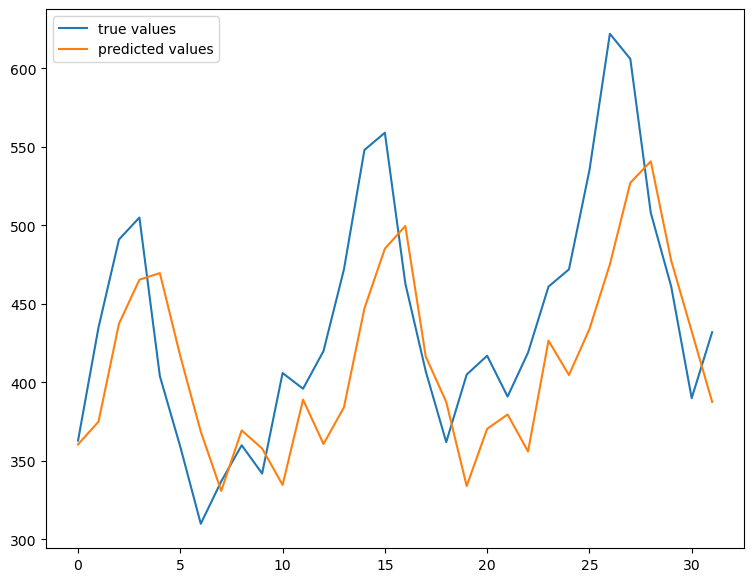

In [15]:
predY = model.predict(testX)
plt.figure(figsize=(9,7))
plt.plot(sc.inverse_transform(testY), label='true values')
plt.plot(sc.inverse_transform(predY), label='predicted values')
plt.legend()